Model trained on contaxts being original_code. 

In [1]:
from transformers import (
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    keras_callbacks,
    TFAutoModelForSeq2SeqLM,
)
import tensorflow as tf
from datasets import Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from huggingface_hub import notebook_login
from datasets import concatenate_datasets
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, generative_qa_utils
from question_answering.paths import generative_qa_paths
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback

In [2]:
df_train, df_val, df_test = core_qa_utils.load_datasets_from_csv(
    generative_qa_paths.java_dataset_dir
)

df_train = pd.concat([df_train, df_val], ignore_index=True)

train_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_test]
)

In [3]:
model_checkpoint = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

c:\Users\Artur\.conda\envs\question_answering\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [4]:
def tokenize_sample(sample, max_tokens=None, padding=False):
    question = sample["questions"].strip()
    context = sample["original_code"].strip()

    return tokenizer(question, context, max_length=max_tokens, padding=padding)

tokenized_train_dataset = train_dataset.map(tokenize_sample)
tokenized_test_dataset = test_dataset.map(tokenize_sample)

print(
    "Max number of tokens in tokenized train dataset: ",
    len(max(tokenized_train_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized test dataset: ",
    len(max(tokenized_test_dataset["input_ids"], key=len)),
)

Map:   0%|          | 0/107737 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (951 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Max number of tokens in tokenized train dataset:  13736
Max number of tokens in tokenized test dataset:  13719


In [5]:
max_length = 256


def filter_samples_below_number_of_tokens(dataset, max_tokens: int):
    indices_to_remove = []

    # Find indices of samples where number of tokens exceeds max number of tokens
    for index, sample in enumerate(dataset):
        tokenized_sample = tokenize_sample(sample)
        if len(tokenized_sample["input_ids"]) > max_tokens:
            indices_to_remove.append(index)

    # Keep only samples with number of tokens less or equal than max number of tokens
    dataset_indices = range(len(dataset))
    filtered_dataset = dataset.select(
        index for index in dataset_indices if index not in set(indices_to_remove)
    )

    return filtered_dataset


filtered_train_dataset = filter_samples_below_number_of_tokens(
    train_dataset, max_tokens=max_length
)
filtered_test_dataset = filter_samples_below_number_of_tokens(
    test_dataset, max_tokens=max_length
)

Parameter 'indices'=<generator object filter_samples_below_number_of_tokens.<locals>.<genexpr> at 0x000002C70EE7BD80> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
print(
    "Number of samples in tokenized train dataset before filtering: ",
    len(train_dataset),
)
print(
    "Number of samples in tokenized test dataset before filtering: ", len(test_dataset)
)

print("\n---------------\n")

print(
    "Number of samples in tokenized train dataset after filtering: ",
    len(filtered_train_dataset),
)
print(
    "Number of samples in tokenized test dataset after filtering: ",
    len(filtered_test_dataset),
)

Number of samples in tokenized train dataset before filtering:  107737
Number of samples in tokenized test dataset before filtering:  2500

---------------

Number of samples in tokenized train dataset after filtering:  74309
Number of samples in tokenized test dataset after filtering:  1696


In [7]:
def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["questions"]]
    contexts = [c.strip() for c in dataset["original_code"]]
    answers = [c.strip() for c in dataset["answers"]]

    inputs = tokenizer(
        questions,
        contexts,
        text_target=answers,
        max_length=max_length,
        truncation=True
    )

    return inputs

In [8]:
tokenized_train_dataset = filtered_train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_train_dataset.column_names,
)
tokenized_test_dataset = filtered_test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_test_dataset.column_names,
)

Map:   0%|          | 0/74309 [00:00<?, ? examples/s]

Map:   0%|          | 0/1696 [00:00<?, ? examples/s]

In [9]:
# Model parameters
training_number = 1

model_name = "java-t5-original"
full_model_name = f"{model_name}-{training_number}"

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
    generative_qa_paths.training_checkpoints_dir
    / full_model_name
    / checkpoint_filename_template
)

# Hub
hub_path = generative_qa_paths.hub_models_location / full_model_name

# Saved models
saved_models_path = generative_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = generative_qa_paths.model_evaluation_dir / full_model_name

# Hyperparameters
batch_size = 4
train_epochs = 3
initial_learning_rate = 3e-5 
end_learning_rate = 0.0

In [10]:
# Load model for fine-tuning
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, from_pt=True)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [11]:
# Dataset preparation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

tf_train_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_train_dataset,
    collator=data_collator,
    batch_size=batch_size,
    shuffle=True
)

tf_test_dataset = core_qa_utils.prepare_tf_dataset(
    model=model,
    hf_dataset=tokenized_test_dataset,
    collator=data_collator,
    batch_size=batch_size,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
# push_to_hub = keras_callbacks.PushToHubCallback(
#     output_dir=full_model_name, tokenizer=tokenizer
# )

time_measure_cb = TimeMeasureCallback()

callbacks = [
    checkpoint_cb,
    # push_to_hub,
    time_measure_cb
]

In [13]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate, end_learning_rate=end_learning_rate, decay_steps=num_train_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
model.compile(optimizer=optimizer)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


In [14]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  109628544 
                                                                 
 decoder (TFT5MainLayer)     multiple                  137949312 
                                                                 
Total params: 222,903,552
Trainable params: 222,903,552
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/3
18577/18577 [==============================] - ETA: 0s - loss: 2.5922
Epoch 1: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\java-t5-original-1\cp-01.ckpt
18577/18577 [==============================] - 2608s 139ms/step - loss: 2.5922
Epoch 2/3
18577/18577 [==============================] - ETA: 0s - loss: 2.1863
Epoch 2: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\java-t5-original-1\cp-02.ckpt
18577/18577 [==============================] - 2601s 140ms/step - loss: 2.1863
Epoch 3/3
18577/18577 [==============================] - ETA: 0s - loss: 2.0300
Epoch 3: saving model to e:\STUDIA\IPS\question-answering\generative-qa\training-checkpoints\java-t5-original-1\cp-03.ckpt
18577/18577 [==============================] - 2620s 141ms/step - loss: 2.0300


In [16]:
# Get best version of the model
best_model, best_epoch = core_qa_utils.get_best_model_from_checkpoints(
    model, history, model_name=full_model_name, metric="loss", remove_checkpoints=True, model_type="generative"
)

In [17]:
# Save best model's weights
generative_qa_utils.save_model(best_model, model_name=full_model_name)

In [18]:
loaded_weights_model = generative_qa_utils.load_weights_into_model(
    model=model, 
    model_name=full_model_name
)

In [19]:
# Get predictions from the best model
loaded_model_evaluation = loaded_weights_model.evaluate(tf_test_dataset)

424/424 [==============================] - 36s 70ms/step - loss: 2.4950


In [20]:
parts_number = 100

test_dataset_pandas = tokenized_test_dataset.to_pandas()
test_dataset_array = np.array_split(test_dataset_pandas, parts_number)

test_datasets_list = []

for row in tqdm(test_dataset_array):
    test_datasets_list.append(core_qa_utils.prepare_tf_dataset(
        model=model,
        hf_dataset=Dataset.from_pandas(row),
        collator=data_collator,
        batch_size=batch_size,
))

c:\Users\Artur\.conda\envs\question_answering\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


In [26]:
# questions_and_answers_df = pd.DataFrame()
index_to_start_from = 89
predictions_list = []
labels_list = []
question_contexts_list = []

i = 0
for dataset in tqdm(test_datasets_list):
    if i < index_to_start_from:
        i = i + 1
        continue
    for batch, labels in tqdm(dataset):
        predictions = generative_qa_utils.generate_predictions(model, batch, max_length)
        decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = labels
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_predictions = [prediction.strip() for prediction in decoded_predictions]
        decoded_labels = [label.strip() for label in decoded_labels]
        predictions_list.extend(decoded_predictions)
        labels_list.extend(decoded_labels)
        question_contexts_list.extend(tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True))

        data = {
            'question_contexts': tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=True),
            'labels': decoded_labels,
            'predictions': decoded_predictions
        }
        questions_and_answers_df = pd.concat([questions_and_answers_df, pd.DataFrame(data)], ignore_index=True)
    i = i + 1

100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


In [27]:
dataset_dataframe_with_predictions = generative_qa_utils.split_questions_and_contexts_into_two_columns(dataframe=questions_and_answers_df)
dataset_dataframe_with_predictions

,questions,contexts,labels,predictions
0,Does the code find the index with the specifie...,public IIndex findIndex ( String name ) retu...,Yes,Yes
1,What does the code find using case insensitive...,public IIndex findIndex ( String name ) retu...,the index with the specified name,the index for the given name
2,In which direction did that move to the tangent?,private float y ( TouchState s ) final float...,from the current touch point,from the tangent
3,What does the code create?,"public MapEntryInfoKey ( Object value, Object...","a new mapentryinfokey, used to keep it in mapv...",a new mapentryinfokey object
4,What did a new mapentryinfokey use?,"public MapEntryInfoKey ( Object value, Object...",to keep it in mapversiontable,to create the mapentryinfokey
...,...,...,...,...
1695,What has the code add to a given xml file?,private static void addLinesToXML ( File inFi...,some lines,the given lines
1696,Where will the lines be inserted directly?,private static void addLinesToXML ( File inFi...,below the first line in the xml,in the xml document
1697,What does the classifier handler have?,public boolean hasDependency ( Capability c )...,a dependency for the specified capability,a dependency
1698,What did the code guarantee?,public static void readBytes ( InputStream is...,to read exactly len bytes. throws error if it ...,that the inputstream is read


In [28]:
bleu_result, rogue_result, meteor_result= generative_qa_utils.get_metrics(dataset_dataframe_with_predictions)
print(
    "BLEU:\n",
    bleu_result,
    "\nROGUE:\n",
    rogue_result,
    "\nMETEOR:\n",
    meteor_result
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU:
 {'bleu': 0.06923370786385327, 'precisions': [0.38605636097084217, 0.14642937598558234, 0.07704972011853803, 0.0443298969072165], 'brevity_penalty': 0.5873282809609568, 'length_ratio': 0.6526685094620455, 'translation_length': 6139, 'reference_length': 9406} 
ROGUE:
 {'rouge1': 0.3574450608405727, 'rouge2': 0.09852175721746853, 'rougeL': 0.3507058394962752, 'rougeLsum': 0.3507132237217083} 
METEOR:
 {'meteor': 0.2318438630536985}


In [29]:
closed_questions_dictionary = generative_qa_utils.get_closed_questions_split_according_to_answer_correctness(dataframe=dataset_dataframe_with_predictions)

number_of_closed_questions = len(closed_questions_dictionary['closed_all'])
number_of_correct_answers = len(closed_questions_dictionary['closed_correct_answer'])
number_of_wrong_answers = len(closed_questions_dictionary['closed_wrong_answer'])

number_of_long_answers_for_closed_questions = len(closed_questions_dictionary['closed_long_answer'])

print("Correct answers: ", number_of_correct_answers)
print("Wrong answers: ", number_of_wrong_answers)
print("Long answers for closed questions: ", number_of_long_answers_for_closed_questions)
print("Wrong answers without the long ones: ", number_of_wrong_answers - number_of_long_answers_for_closed_questions)

Correct answers:  133
Wrong answers:  57
Long answers for closed questions:  0
Wrong answers without the long ones:  57


In [30]:
# Save all relevant training and evaluation metrics to a json file.
evaluation_data = {
    "training": {
        "metrics": history.history,
        "attempted_epochs": train_epochs,
        "best_epoch": best_epoch,
        "training_time": time_measure_cb.total_training_time(),
        "gpu": core_qa_utils.get_gpu_name(),
    },
    "test_set": {
        "loss": loaded_model_evaluation,
        "bleu": bleu_result,
        "rogue": rogue_result,
        "meteor": meteor_result,
        "closed_questions": {
            "closed_questions_number": number_of_closed_questions,
            "correct_answers_number": number_of_correct_answers,
            "wrong_answers_number": number_of_wrong_answers,
            "long_answers_for_closed_questions_number": number_of_long_answers_for_closed_questions,
        }
    },
}

core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

In [31]:
dataset_dataframe_with_predictions = generative_qa_utils.calculate_bleus_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_rouges_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions = generative_qa_utils.calculate_meteor_for_each_sample(dataset_dataframe_with_predictions)
dataset_dataframe_with_predictions

1700it [00:30, 55.78it/s]
1700it [14:55,  1.90it/s]
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Artur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
1700it [00:14, 118.93it/s]


,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,Does the code find the index with the specifie...,public IIndex findIndex ( String name ) retu...,Yes,Yes,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.500000
1,What does the code find using case insensitive...,public IIndex findIndex ( String name ) retu...,the index with the specified name,the index for the given name,0.0,0.666667,0.200000,0.666667,0.200000,0.666667,0.526042
2,In which direction did that move to the tangent?,private float y ( TouchState s ) final float...,from the current touch point,from the tangent,0.0,0.666667,0.500000,0.500000,0.333333,0.500000,0.390625
3,What does the code create?,"public MapEntryInfoKey ( Object value, Object...","a new mapentryinfokey, used to keep it in mapv...",a new mapentryinfokey object,0.0,0.750000,0.666667,0.461538,0.363636,0.461538,0.313239
4,What did a new mapentryinfokey use?,"public MapEntryInfoKey ( Object value, Object...",to keep it in mapversiontable,to create the mapentryinfokey,0.0,0.250000,0.000000,0.222222,0.000000,0.222222,0.102041
...,...,...,...,...,...,...,...,...,...,...,...
1695,What has the code add to a given xml file?,private static void addLinesToXML ( File inFi...,some lines,the given lines,0.0,0.333333,0.000000,0.400000,0.000000,0.400000,0.238095
1696,Where will the lines be inserted directly?,private static void addLinesToXML ( File inFi...,below the first line in the xml,in the xml document,0.0,0.750000,0.666667,0.545455,0.444444,0.545455,0.439469
1697,What does the classifier handler have?,public boolean hasDependency ( Capability c )...,a dependency for the specified capability,a dependency,0.0,1.000000,1.000000,0.500000,0.333333,0.500000,0.334821
1698,What did the code guarantee?,public static void readBytes ( InputStream is...,to read exactly len bytes. throws error if it ...,that the inputstream is read,0.0,0.200000,0.000000,0.125000,0.000000,0.125000,0.044248


In [32]:
thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
prediction_counts_per_metric_range = generative_qa_utils.calculate_prediction_counts_per_metric_range(dataset_dataframe_with_predictions, thresholds)
prediction_counts_per_metric_range

{'bleu': [1655, 12, 13, 6, 14],
 'bleu1': [582, 316, 273, 191, 338],
 'bleu2': [1353, 116, 106, 33, 92],
 'rouge1': [634, 458, 248, 145, 215],
 'rouge2': [1391, 166, 62, 32, 49],
 'rougeL': [642, 480, 232, 134, 212],
 'meteor': [1006, 286, 256, 78, 74]}

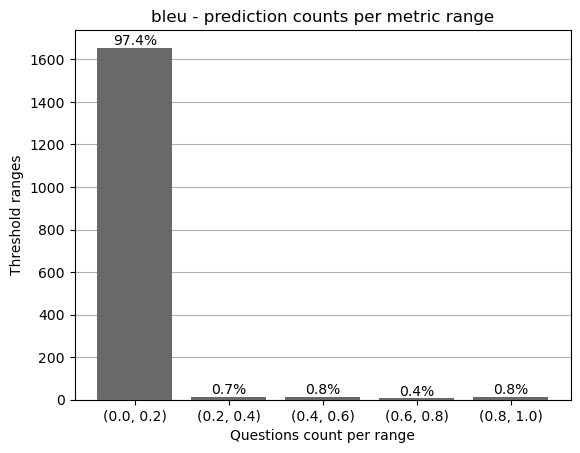

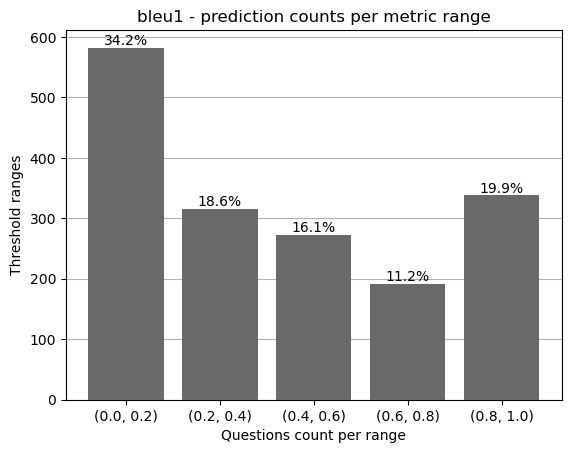

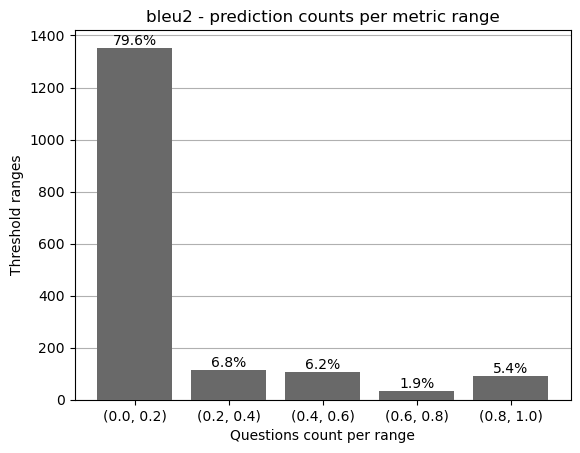

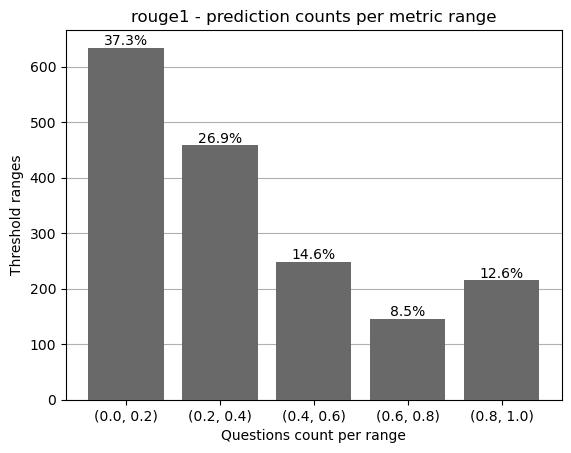

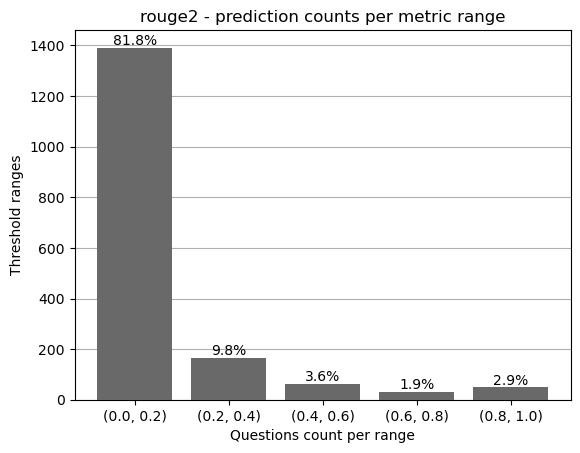

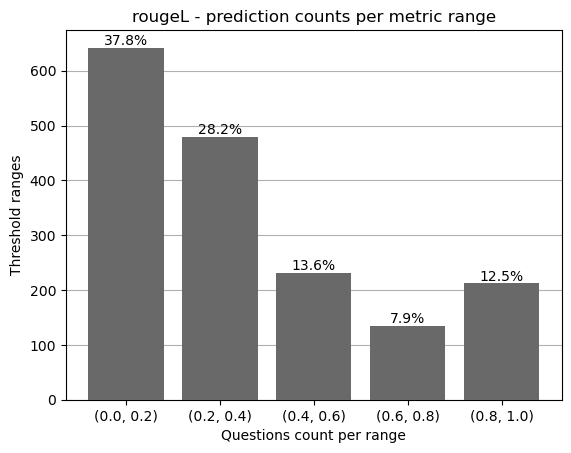

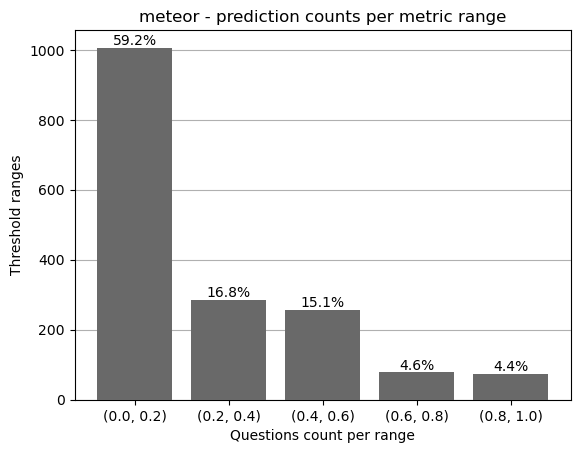

In [33]:
generative_qa_utils.plot_prediction_counts_per_metric_range_diagrams(
    prediction_counts_per_metric = prediction_counts_per_metric_range,
    thresholds=thresholds,
    figure_directory_path=model_evaluation_dir
    )

In [34]:
dataset_dataframe_with_predictions.to_csv(
    model_evaluation_dir / "test_set_sample_generation.csv", index=True, index_label="index"
)

In [35]:
dataset_dataframe_with_predictions = pd.read_csv(model_evaluation_dir / "test_set_sample_generation.csv")
dataset_dataframe_with_predictions

,index,questions,contexts,labels,predictions,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
0,0,Does the code find the index with the specifie...,public IIndex findIndex ( String name ) retu...,Yes,Yes,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.500000
1,1,What does the code find using case insensitive...,public IIndex findIndex ( String name ) retu...,the index with the specified name,the index for the given name,0.0,0.666667,0.200000,0.666667,0.200000,0.666667,0.526042
2,2,In which direction did that move to the tangent?,private float y ( TouchState s ) final float...,from the current touch point,from the tangent,0.0,0.666667,0.500000,0.500000,0.333333,0.500000,0.390625
3,3,What does the code create?,"public MapEntryInfoKey ( Object value, Object...","a new mapentryinfokey, used to keep it in mapv...",a new mapentryinfokey object,0.0,0.750000,0.666667,0.461538,0.363636,0.461538,0.313239
4,4,What did a new mapentryinfokey use?,"public MapEntryInfoKey ( Object value, Object...",to keep it in mapversiontable,to create the mapentryinfokey,0.0,0.250000,0.000000,0.222222,0.000000,0.222222,0.102041
...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1695,What has the code add to a given xml file?,private static void addLinesToXML ( File inFi...,some lines,the given lines,0.0,0.333333,0.000000,0.400000,0.000000,0.400000,0.238095
1696,1696,Where will the lines be inserted directly?,private static void addLinesToXML ( File inFi...,below the first line in the xml,in the xml document,0.0,0.750000,0.666667,0.545455,0.444444,0.545455,0.439469
1697,1697,What does the classifier handler have?,public boolean hasDependency ( Capability c )...,a dependency for the specified capability,a dependency,0.0,1.000000,1.000000,0.500000,0.333333,0.500000,0.334821
1698,1698,What did the code guarantee?,public static void readBytes ( InputStream is...,to read exactly len bytes. throws error if it ...,that the inputstream is read,0.0,0.200000,0.000000,0.125000,0.000000,0.125000,0.044248


In [36]:
dataframe_predictions_and_question_types = generative_qa_utils.add_question_types_to_dataset_dataframe(dataset_predictions_dataframe=dataset_dataframe_with_predictions)

In [37]:
only_metric_columns_dataframe = dataframe_predictions_and_question_types[['bleu', 'bleu1', 'bleu2', 'rouge1', 'rouge2', 'rougeL', 'meteor', 'question_type']]
metric_mean_values_dataframe = only_metric_columns_dataframe.groupby(['question_type']).mean()
metric_mean_values_dataframe.insert(
    loc=0,
    column='question_type',
    value=list(only_metric_columns_dataframe.groupby(['question_type']).groups.keys())
)
metric_mean_values_dataframe.to_csv(
    model_evaluation_dir / "metric_mean_values.csv", index=False
)
metric_mean_values_dataframe

,question_type,bleu,bleu1,bleu2,rouge1,rouge2,rougeL,meteor
question_type,,,,,,,,
closed,closed,0.000000,0.700000,0.000000,0.700000,0.000000,0.700000,0.350000
for_whats,for_whats,0.004613,0.319609,0.080688,0.223358,0.040646,0.210313,0.122682
hows,hows,0.020594,0.255334,0.098846,0.220105,0.085875,0.218163,0.161448
others,others,0.010638,0.315245,0.085983,0.256762,0.074213,0.248694,0.181639
whats,whats,0.020146,0.437029,0.156801,0.344632,0.121917,0.335942,0.236016
whens,whens,0.015171,0.186977,0.043924,0.168278,0.038969,0.163470,0.115309
wheres,wheres,0.024179,0.388469,0.198901,0.370688,0.178974,0.368940,0.286227


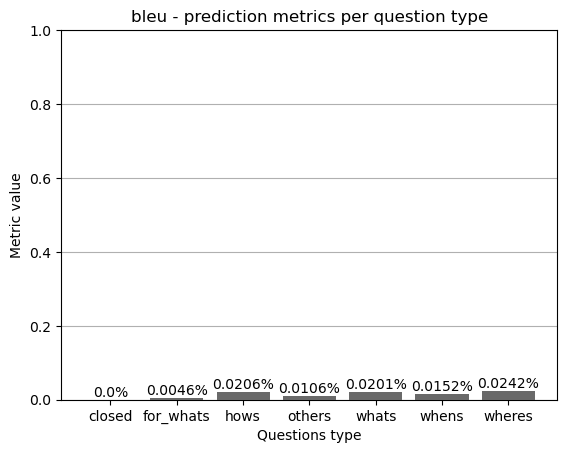

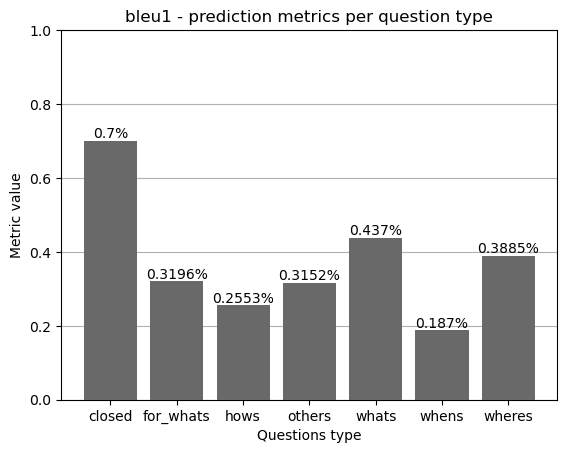

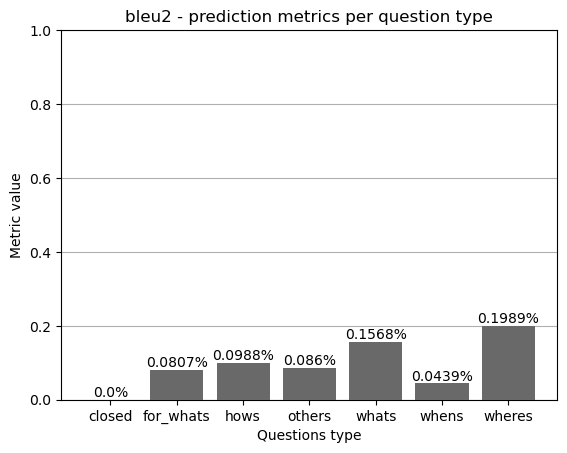

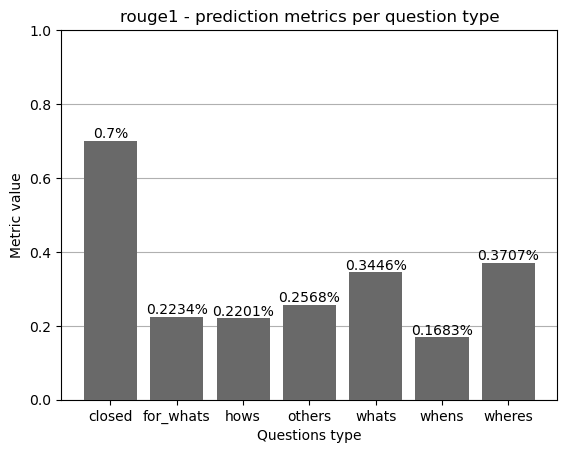

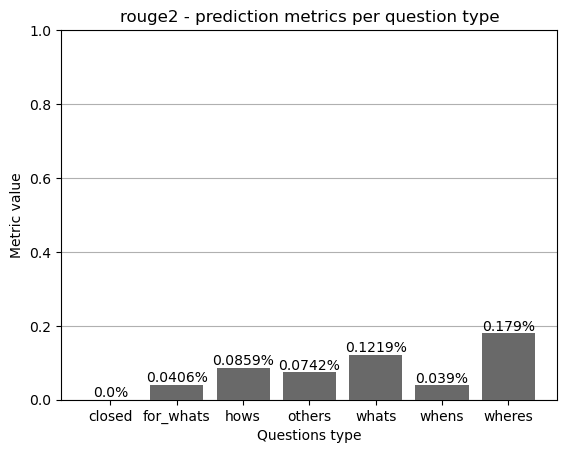

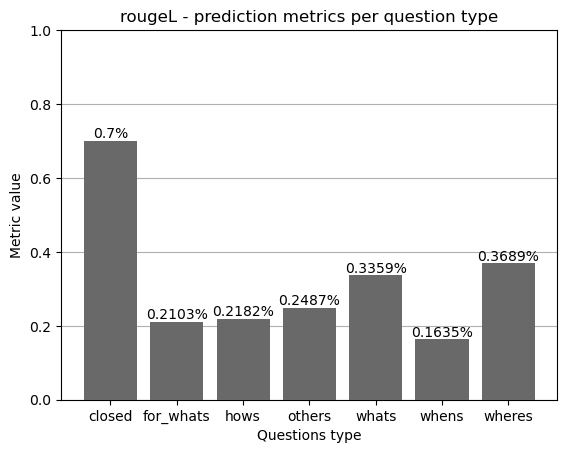

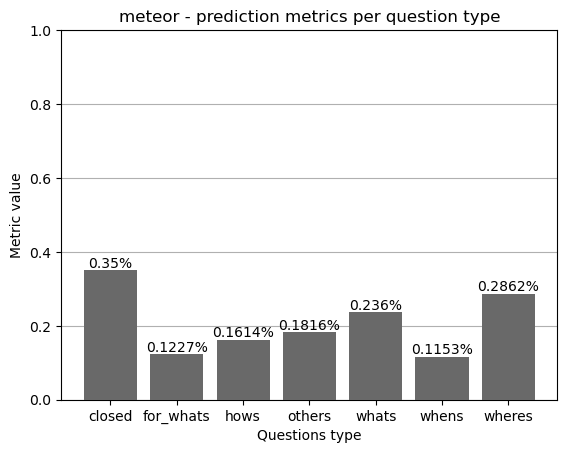

In [38]:
generative_qa_utils.plot_prediction_metrics_per_question_type_diagram(
    metric_mean_values_dataframe=metric_mean_values_dataframe,
    figure_directory_path=model_evaluation_dir / 'figures' / 'metrics-per-type'
)

In [39]:
question_type_metrics_dictionary = generative_qa_utils.count_prediction_numbers_per_metric_range_for_specific_question_type(dataframe_predictions_and_question_types)
generative_qa_utils.save_question_type_metrics_dictionary_to_csv(model_evaluation_dir=model_evaluation_dir, question_type_metrics_dictionary=question_type_metrics_dictionary)
question_type_metrics_dictionary = generative_qa_utils.read_question_type_metrics_dictionary_from_csv(model_evaluation_dir=model_evaluation_dir)
question_type_metrics_dictionary

{'whats':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)  1035    323    806     366     834     373     624
 1      1  (0.2, 0.4)    10    194     75     318     122     336     236
 2      2  (0.4, 0.6)     9    221     85     196      49     183      89
 3      3  (0.6, 0.8)     4    150     21     120      23     111      58
 4      4  (0.8, 1.0)    11    181     82      69      41      66      62,
 'wheres':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0  (0.0, 0.2)    85     24     59      22      58      22      45
 1      1  (0.2, 0.4)     1     28      9      34      17      34      17
 2      2  (0.4, 0.6)     0     14     10      18       5      18      12
 3      3  (0.6, 0.8)     1     11      3       7       3       7       7
 4      4  (0.8, 1.0)     1     11      7       7       5       7       7,
 'hows':    index      ranges  bleu  bleu1  bleu2  rouge1  rouge2  rougeL  meteor
 0      0

In [40]:
generative_qa_utils.plot_prediction_counts_per_metric_range_per_question_type_diagram(
    question_type_metrics_dictionary=question_type_metrics_dictionary,
    figure_directory_path=model_evaluation_dir / 'figures' / 'counts-per-metric-range'
)